In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from enum import unique
from sklearn import preprocessing

c:\Users\Rodri\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
raw_df = pd.read_csv("https://raw.githubusercontent.com/rmarquez93/data_sources/main/imdb_top_1000.csv")

In [3]:
raw_df.shape

(1000, 16)

In [4]:
raw_df.head(5)

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


Goal: Predict the IMDB rating based on the rest of the features available.

Three features will be converted into continous numerical values. For these three variables a checking on the content that doesn't seem to be numerical is performed.

In [5]:
print("Variable: Released_Year")
print(raw_df[pd.to_numeric(raw_df["Released_Year"], errors='coerce').isnull()]["Released_Year"])
print("\n"+"*"*60)

print("Variable: Runtime")
print(raw_df[pd.to_numeric(raw_df["Runtime"], errors='coerce').isnull()]["Runtime"])
print("\n"+"*"*60)

print("Variable: Gross")
print(raw_df[pd.to_numeric(raw_df["Gross"], errors='coerce').isnull()]["Gross"])
print("\n"+"*"*60)

Variable: Released_Year
966    PG
Name: Released_Year, dtype: object

************************************************************
Variable: Runtime
0      142 min
1      175 min
2      152 min
3      202 min
4       96 min
        ...   
995    115 min
996    201 min
997    118 min
998     97 min
999     86 min
Name: Runtime, Length: 1000, dtype: object

************************************************************
Variable: Gross
0       28,341,469
1      134,966,411
2      534,858,444
3       57,300,000
4        4,360,000
          ...     
995            NaN
996            NaN
997     30,500,000
998            NaN
999            NaN
Name: Gross, Length: 1000, dtype: object

************************************************************


Deleting "mins" from the text of movie duration and converting it to integer later on. Converting to float the "gross" revenue too.

In [6]:
raw_df["Runtime"] = raw_df["Runtime"].str.replace("min","")
raw_df["Runtime"] = raw_df["Runtime"].str.strip()
raw_df["Runtime"] = raw_df["Runtime"].astype(int)
raw_df["Released_Year"] = raw_df["Released_Year"].replace("PG",np.nan)
#The variable is converted to float to handle null values. Null treatment will be done later on the script.
raw_df["Released_Year"] = raw_df["Released_Year"].astype(float) 
raw_df["Gross"] = raw_df["Gross"].str.replace(",","").astype(float)

# Exploratory Analysis

Overview of the data types that are shown in the dataframe.

In [7]:
for i in raw_df.columns:
  print(i," : ",raw_df[i].dtype)


Poster_Link  :  object
Series_Title  :  object
Released_Year  :  float64
Certificate  :  object
Runtime  :  int32
Genre  :  object
IMDB_Rating  :  float64
Overview  :  object
Meta_score  :  float64
Director  :  object
Star1  :  object
Star2  :  object
Star3  :  object
Star4  :  object
No_of_Votes  :  int64
Gross  :  float64


Null values general overview

In [8]:
raw_df.isnull().sum()

Poster_Link        0
Series_Title       0
Released_Year      1
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

In [9]:
raw_df.describe()

,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
count,999.000000,1000.000000,1000.000000,843.000000,1.000000e+03,8.310000e+02
mean,1991.217217,122.891000,7.949300,77.971530,2.736929e+05,6.803475e+07
std,23.297025,28.093671,0.275491,12.376099,3.273727e+05,1.097500e+08
min,1920.000000,45.000000,7.600000,28.000000,2.508800e+04,1.305000e+03
25%,1976.000000,103.000000,7.700000,70.000000,5.552625e+04,3.253559e+06
50%,1999.000000,119.000000,7.900000,79.000000,1.385485e+05,2.353089e+07
75%,2009.000000,137.000000,8.100000,87.000000,3.741612e+05,8.075089e+07
max,2020.000000,321.000000,9.300000,100.000000,2.343110e+06,9.366622e+08


count                                                  1000
unique                                                 1000
top       https://m.media-amazon.com/images/M/MV5BMDFkYT...
freq                                                      1
Name: Poster_Link, dtype: object 
--------------------------------

count         1000
unique         999
top       Drishyam
freq             2
Name: Series_Title, dtype: object 
--------------------------------



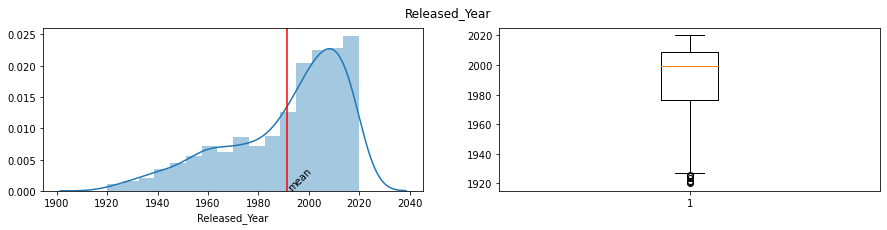

Asimetría: -0.939346641352243
Curtosis: -0.021431891218695487
count     999.000000
mean     1991.217217
std        23.297025
min      1920.000000
25%      1976.000000
50%      1999.000000
75%      2009.000000
max      2020.000000
Name: Released_Year, dtype: float64 
Coeficiente de variación de Pearson: 0.011699891223762344 
--------------------------------

count     899
unique     16
top         U
freq      234
Name: Certificate, dtype: object 
--------------------------------

count    1000.000000
mean      122.891000
std        28.093671
min        45.000000
25%       103.000000
50%       119.000000
75%       137.000000
max       321.000000
Name: Runtime, dtype: float64 
--------------------------------

count      1000
unique      202
top       Drama
freq         85
Name: Genre, dtype: object 
--------------------------------



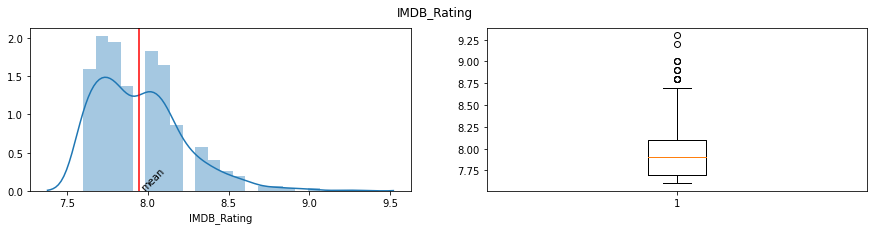

Asimetría: 1.016964453611272
Curtosis: 1.4327269987500322
count    1000.000000
mean        7.949300
std         0.275491
min         7.600000
25%         7.700000
50%         7.900000
75%         8.100000
max         9.300000
Name: IMDB_Rating, dtype: float64 
Coeficiente de variación de Pearson: 0.03465603354911869 
--------------------------------

count                                                  1000
unique                                                 1000
top       Two imprisoned men bond over a number of years...
freq                                                      1
Name: Overview, dtype: object 
--------------------------------



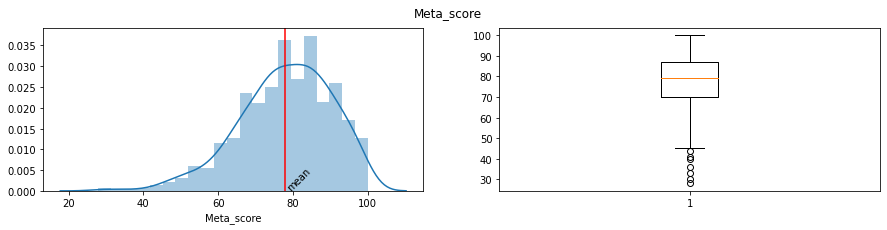

Asimetría: -0.6052248305009935
Curtosis: 0.4208306168018683
count    843.000000
mean      77.971530
std       12.376099
min       28.000000
25%       70.000000
50%       79.000000
75%       87.000000
max      100.000000
Name: Meta_score, dtype: float64 
Coeficiente de variación de Pearson: 0.15872587454756587 
--------------------------------

count                 1000
unique                 548
top       Alfred Hitchcock
freq                    14
Name: Director, dtype: object 
--------------------------------

count          1000
unique          660
top       Tom Hanks
freq             12
Name: Star1, dtype: object 
--------------------------------

count            1000
unique            841
top       Emma Watson
freq                7
Name: Star2, dtype: object 
--------------------------------

count             1000
unique             891
top       Rupert Grint
freq                 5
Name: Star3, dtype: object 
--------------------------------

count              1000
unique     

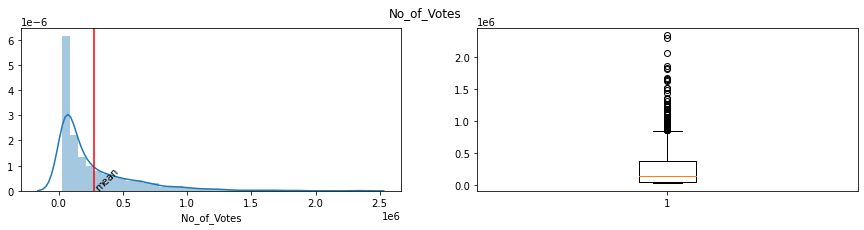

Asimetría: 2.30001058546554
Curtosis: 6.89509932739565
count    1.000000e+03
mean     2.736929e+05
std      3.273727e+05
min      2.508800e+04
25%      5.552625e+04
50%      1.385485e+05
75%      3.741612e+05
max      2.343110e+06
Name: No_of_Votes, dtype: float64 
Coeficiente de variación de Pearson: 1.1961314698944645 
--------------------------------



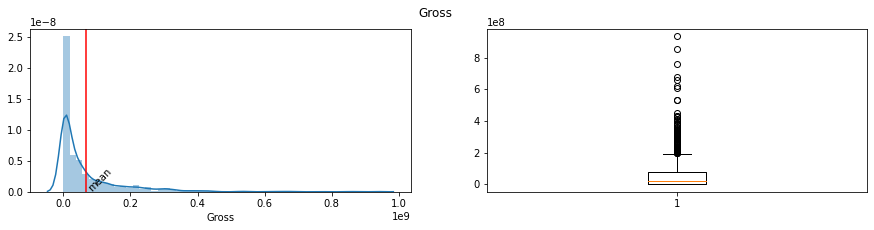

Asimetría: 3.1301343288134538
Curtosis: 13.914472951089826
count    8.310000e+02
mean     6.803475e+07
std      1.097500e+08
min      1.305000e+03
25%      3.253559e+06
50%      2.353089e+07
75%      8.075089e+07
max      9.366622e+08
Name: Gross, dtype: float64 
Coeficiente de variación de Pearson: 1.6131468372098896 
--------------------------------



In [10]:
#En este punto se iterará sobre cada variable para obtener información
# estadística primaria sobre la estructura de las variables.

#Se obtienen entonces los principales estadísticos y, si la variable es float o int,
# se llama a la función freq_table para posteriormente
#Dar información sobre asimetría, curtosis y CV de Spearman.

for columnName in raw_df.columns:
  
  if (raw_df[columnName].dtype == np.float64 or raw_df[columnName].dtype == np.int64) and raw_df[columnName].isnull().sum() != len(raw_df[columnName]):
    plt.figure(figsize = (15,3))
    plt.suptitle(columnName)
    plt.subplot(1,2,1)
    sns.distplot(raw_df[columnName])
    plt.axvline(raw_df[columnName].mean(), color= "red")
    plt.text(raw_df[columnName].mean(),0,'mean',rotation=45)
    plt.subplot(1,2,2)
    plt.boxplot(raw_df[~np.isnan(raw_df[columnName])][columnName]) 
    plt.show()
    print("Asimetría: {}".format(raw_df[columnName].skew()))
    print("Curtosis: {}".format(raw_df[columnName].kurt()))
    spearman = raw_df[columnName].std()/raw_df[columnName].mean()
    print(raw_df[columnName].describe(),"\nCoeficiente de variación de Pearson: {} \n--------------------------------\n".format(spearman))
  else:
    print(raw_df[columnName].describe(),"\n--------------------------------\n")

Por hacer:

* Visualización (ej.: apertura por género, por director, etc.).
* Trasnformaciones (ej.: transformación logarítmica) en valores extremos. Normalización de las variables.
* Boxplots para ver outliers.
* Análisis de correlaciones.
* Completado/eliminación de nulos. (ver si los nulos refieren a una categoría en especial o algo por el estilo)
* Primer modelo -> AD
* Agregar un análisis con la descripción de la peli (ej.: palabra mas repetida por género o algo por el estilo)



Ejemplos:

https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows/code?datasetId=1131493&sortBy=voteCount&language=Python&outputs=null

https://www.kaggle.com/code/cloudy17/imdb-plotly-power

https://www.kaggle.com/code/mruanova/imdb-movies-gross-prediction-using-xgboost

https://www.kaggle.com/code/harshitshankhdhar/eda-on-imdb-movies-dataset/notebook

En este punto, investigo la variable "Certificate" que corresponde a las calificaciones que se le dan a las películas para su exhibición pública.

Como primer punto, investigo la composición de dicha columna:

In [11]:
raw_df["Certificate"].unique()

array(['A', 'UA', 'U', 'PG-13', 'R', nan, 'PG', 'G', 'Passed', 'TV-14',
       '16', 'TV-MA', 'Unrated', 'GP', 'Approved', 'TV-PG', 'U/A'],
      dtype=object)

Los valores "U", "U/A","A" y "S" corresponde a la certificación otorgada por el *Central Board of Film Certification* del gobierno de India. A su vez, los valores "G", "PG" y "R" son de la *Motion Picture Association* de Estados Unidos y es la mas extendida globalmente. Por último, el valor "TV-PG" corresponde a la *Federal Communications Commission* de Estados Unidos y se rige para contenido emitido en TV. 

A partir de lo anterior voy a tomar dos acciones: convertir todos los valores a una misma escala (la de la MPAA) y por otro, tratar aquellos valores que no entran en ninguna de las escalas mencionadas.

| CBFC | MPAA Movies | MPAA TV | Description |
| - | - | - | - |
| U | G, PG | TV-Y, TV-Y7, TV-G, TV-PG | Unrestricted public exhibition, suitable for all ages |
| UA | PG-13 | TV-14 | Unrestricted public exhibition but with caution to give parental guidance for under 12 |
| A | R, NC-17 | TV-MA | Only adults are allowed to view these programs |


In [12]:
raw_df[~raw_df["Certificate"].isin(["G","PG","PG-13","R"])]["Certificate"].unique()

array(['A', 'UA', 'U', nan, 'Passed', 'TV-14', '16', 'TV-MA', 'Unrated',
       'GP', 'Approved', 'TV-PG', 'U/A'], dtype=object)

In [13]:
raw_df["Certificate"] = raw_df["Certificate"].str.replace("/","").replace("GP","PG")

mapping = {"A":"R","UA":"PG-13","U":"G", "TV-PG":"G", "TV-14":"PG-13", "TV-MA":"R"}

raw_df = raw_df.replace({"Certificate":mapping})

raw_df[~raw_df["Certificate"].isin(["G","PG","PG-13","R"])]["Certificate"].unique()

array([nan, 'Passed', '16', 'Unrated', 'Approved'], dtype=object)

Asumo que "Passed" o "Approved" es que tienen la certificación mas apta para todo público (G).

In [14]:
raw_df = raw_df.replace({"Certificate":{"Passed":"G", "Approved":"G"}})

raw_df["Certificate"].unique()

array(['R', 'PG-13', 'G', nan, 'PG', '16', 'Unrated'], dtype=object)

In [15]:
raw_df["Certificate"] = raw_df["Certificate"].replace("16", np.nan).replace("Unrated",np.nan)

In [16]:
raw_df["Certificate"].unique()

array(['R', 'PG-13', 'G', nan, 'PG'], dtype=object)

Cambio las variables categóricas a categórica ordinal.

In [17]:
raw_df = raw_df.replace({"Certificate":{
    "G":1,
    "PG":1,
    "PG-13":2,
    "R":3
}})

# Análisis de valores faltantes:

In [18]:
raw_df.isnull().sum()

Poster_Link        0
Series_Title       0
Released_Year      1
Certificate      103
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

Primero, elimino el valor nulo en Released_Year debido a que es solo un registro.

In [19]:
raw_df = raw_df[~pd.isnull(raw_df["Released_Year"])].copy()

In [20]:
#Creating a column in the dataframe to assign a decade 
raw_df["Released_Decade"] = (10*(raw_df.Released_Year//10))

En el caso de gross, hay 169 registros faltantes sobre un total de 1000 registros. Se buscará establecer algún patrón donde dicho registros se encuentran (ej.: por año/década) para determinar el tratamiento a seguir para dichos datos.

<BarContainer object of 11 artists>

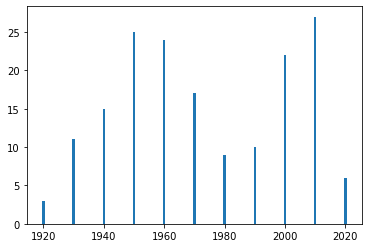

In [21]:
nulls_by_decade = raw_df[pd.isnull(raw_df["Gross"])].groupby(["Released_Decade"])["Released_Decade"].count().to_frame()
nulls_by_decade.rename(columns={"Released_Decade":"Occurrences"}, inplace=True)
nulls_by_decade.reset_index(inplace=True)
nulls_by_decade
plt.bar(nulls_by_decade["Released_Decade"], nulls_by_decade["Occurrences"])

Por década no se nota a simple vista que haya algún motivo o década en concreto donde no se tenga información de recaudación especificamente. El siguiente paso va a ser inputar los valores faltantes basándome en la variable Meta_score. Para realizarlo, elimino aquellos registros que tienen valores simultáneamente en ambas variables.

In [22]:
raw_df = raw_df[~((pd.isnull(raw_df["Meta_score"]))&(pd.isnull(raw_df["Gross"])))].copy()

,Meta_score,Occurrences
0,51,1
1,58,1
2,59,1
3,60,1
4,62,1


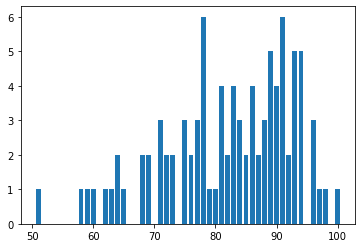

In [23]:
nulls_by_Meta_score = raw_df.loc[pd.isnull(raw_df["Gross"]),["Meta_score","Gross"]].copy() #pd.isnull(raw_df["Gross"])
nulls_by_Meta_score["Meta_score"] = nulls_by_Meta_score["Meta_score"].astype("int") 
nulls_by_Meta_score = nulls_by_Meta_score[pd.isnull(nulls_by_Meta_score["Gross"])].groupby("Meta_score")["Meta_score"].count().to_frame().copy()
nulls_by_Meta_score.rename(columns={"Meta_score":"Occurrences"}, inplace=True)
nulls_by_Meta_score.reset_index(inplace=True)
plt.bar(nulls_by_Meta_score["Meta_score"], nulls_by_Meta_score["Occurrences"])
nulls_by_Meta_score.head()

In [24]:
raw_df = raw_df.loc[~pd.isnull(raw_df["Gross"])].copy()

Los de metascore los elimino, porque lo único que podría hacer es aproximarme por el IMDB rating, que es la variable objetivo.

In [25]:
raw_df = raw_df.loc[~pd.isnull(raw_df["Meta_score"])].copy()

La clasificación, les pongo la moda a los valores faltantes.

In [26]:
raw_df.loc[pd.isnull(raw_df["Certificate"]),"Certificate"] = raw_df["Certificate"].mode().values[0]

TODO: Tengo que agregar un análisis de imputación de los faltantes de Clasificación. Los elimino? Les pongo la moda? Pongo la moda por subconjunto?

# Análisis de Outliers

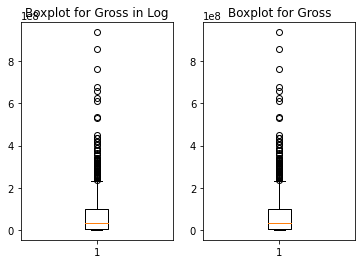

In [27]:
raw_df["Gross_Log"] = raw_df["Gross"]#np.log(raw_df["Gross"])
raw_df["Gross_Log"]
plt.subplot(1,2,1)
plt.title("Boxplot for Gross in Log")
plt.boxplot(raw_df[~np.isnan(raw_df["Gross_Log"])]["Gross_Log"])
plt.subplot(1,2,2)
plt.title("Boxplot for Gross")
plt.boxplot(raw_df[~np.isnan(raw_df["Gross"])]["Gross"])
plt.show()

In [28]:
raw_df[~raw_df["Certificate"].isin(["A","U/A", "U", "S"])]["Certificate"].unique()

array([3., 2., 1.])

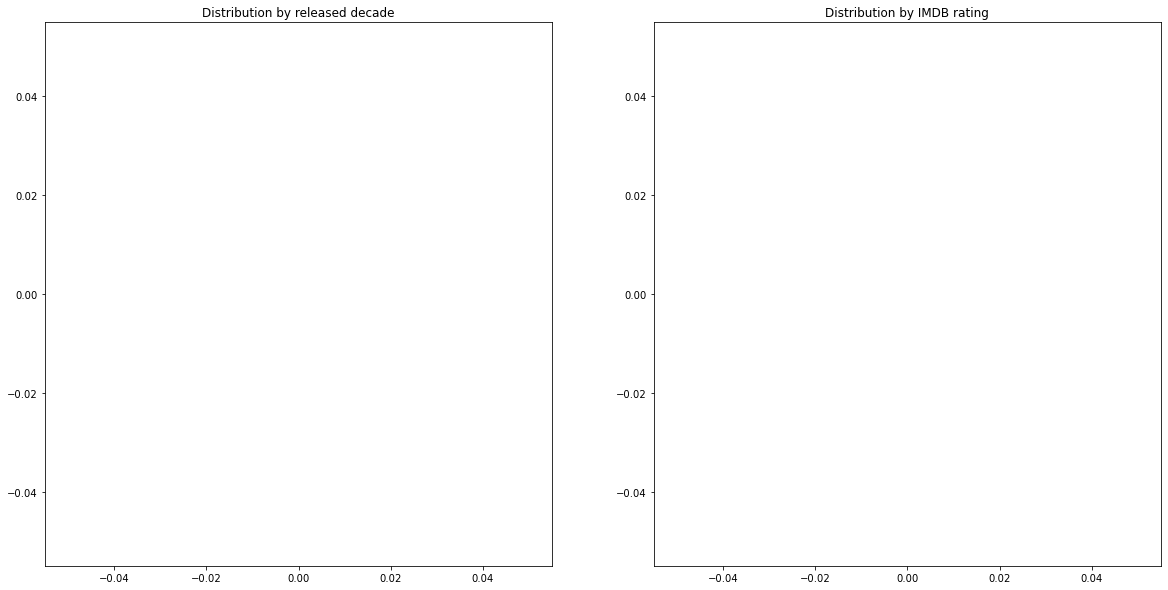

In [29]:
#Calculo de IQR
Q3 = raw_df["Gross_Log"].quantile(0.75)
Q1 = raw_df["Gross_Log"].quantile(0.25)
IQR = Q3-Q1


outliers_df = raw_df.loc[raw_df["Gross_Log"]<= (Q1-IQR*1.5),["Released_Decade","IMDB_Rating","Gross_Log"]]
outliers_df["IMDB_Rating"] = outliers_df["IMDB_Rating"].astype("int")
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.title("Distribution by released decade")
plt.bar(outliers_df["Released_Decade"].value_counts().index,outliers_df["Released_Decade"].value_counts())
plt.subplot(1,2,2)
plt.title("Distribution by IMDB rating")
plt.bar(outliers_df["IMDB_Rating"].value_counts().index,outliers_df["IMDB_Rating"].value_counts())
plt.show()

Ejemplo: haciendo un capping a los datos para recortar los valores extremos.

In [30]:
#por ahora lo dejo porque el modelo de AD es robusto contra valores extremos

In [31]:
outliers_df["Released_Decade"].value_counts()

Series([], Name: count, dtype: int64)

Puedo dejar los outliers y pasar a usar árboles de decisión, que son menos sensibles a valores atípicos.


# Distribution of movies trhoughout the years



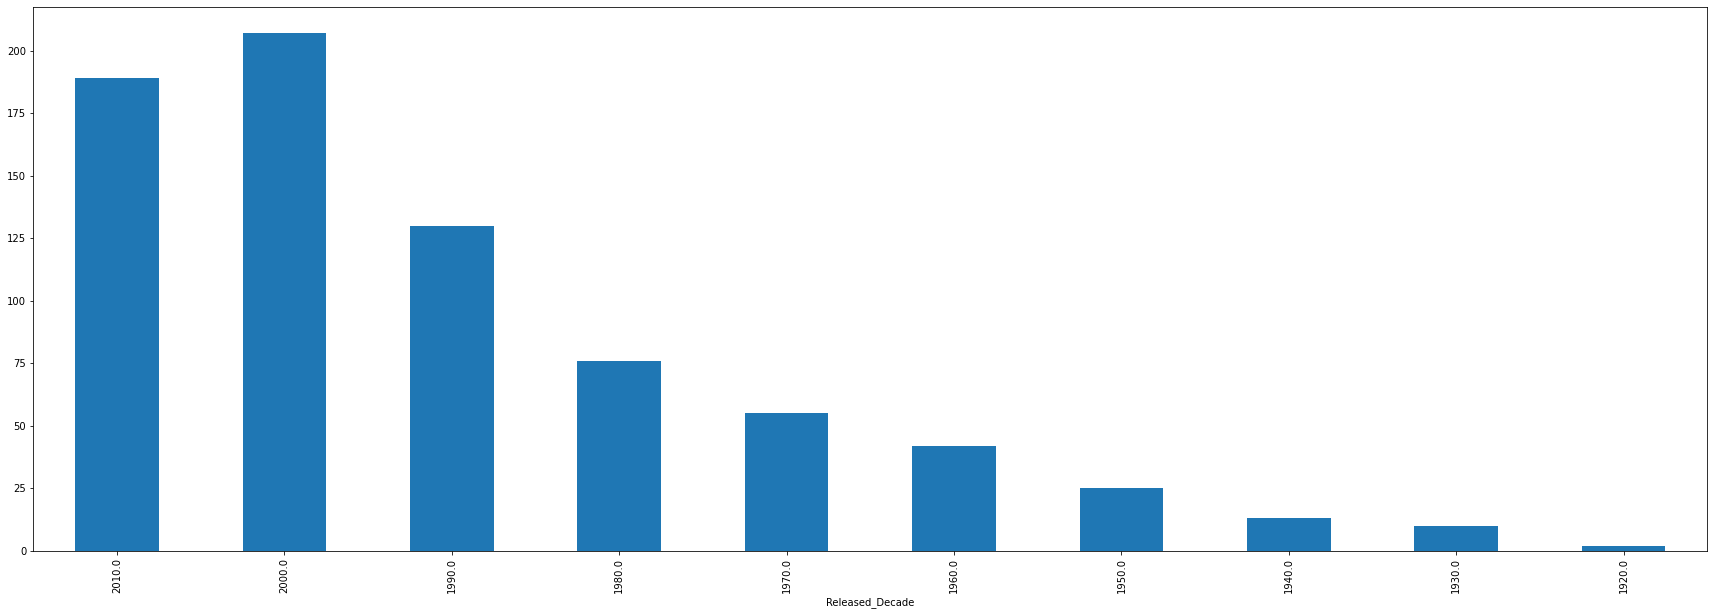

In [32]:
plt.figure(figsize = (30,10))
raw_df.Released_Decade.value_counts().sort_index(ascending=False).plot(kind = "bar")

Switching to categorical variable as it is not a time measure and rather an ordinal categorical variable.

In [33]:
raw_df["Released_Decade"] = raw_df["Released_Decade"].astype("str")
raw_df["Released_Decade"] = raw_df.apply(lambda row: row["Released_Decade"].split(".")[0], axis=1)
raw_df["Released_Decade"]

0      1990
1      1970
2      2000
3      1970
4      1950
       ... 
990    1970
991    1970
992    1960
994    1960
997    1950
Name: Released_Decade, Length: 749, dtype: object

# Feature selection

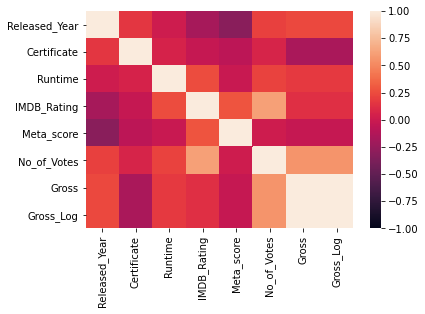

In [34]:
#TEST -- Mapa de correlacion
import seaborn as sns 

correlation_df = raw_df.corr(numeric_only = True)
sns.heatmap(correlation_df, vmin =-1, vmax=1)

In [35]:
correlation_df

,Released_Year,Certificate,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross,Gross_Log
Released_Year,1.000000,0.159093,0.012976,-0.179065,-0.306421,0.203316,0.235951,0.235951
Certificate,0.159093,1.000000,0.061536,-0.028670,-0.077583,0.064129,-0.158766,-0.158766
Runtime,0.012976,0.061536,1.000000,0.257201,-0.012183,0.217457,0.172226,0.172226
IMDB_Rating,-0.179065,-0.028670,0.257201,1.000000,0.282887,0.614358,0.129378,0.129378
Meta_score,-0.306421,-0.077583,-0.012183,0.282887,1.000000,0.010298,-0.030560,-0.030560
No_of_Votes,0.203316,0.064129,0.217457,0.614358,0.010298,1.000000,0.556003,0.556003
Gross,0.235951,-0.158766,0.172226,0.129378,-0.030560,0.556003,1.000000,1.000000
Gross_Log,0.235951,-0.158766,0.172226,0.129378,-0.030560,0.556003,1.000000,1.000000


Del análisis primario de correlaciones, se deciden quitar algunas variables que superan el límite absoluto de 0.50 con el fin de evitar posible colinealidad a la hora de generar el modelo predictivo.

Las variables a eliminar son:

1) Released_Year 

2) Gross

3) No_of_Votes

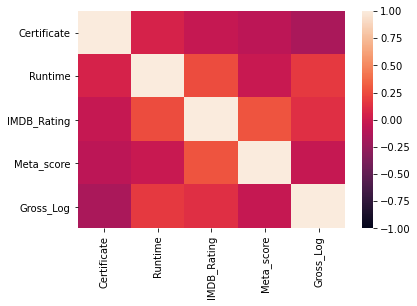

In [36]:
correlation_df = raw_df.drop(["Released_Year", "Gross", "No_of_Votes"], axis=1).corr(numeric_only = True)
sns.heatmap(correlation_df, vmin =-1, vmax=1)

In [37]:
correlation_df

,Certificate,Runtime,IMDB_Rating,Meta_score,Gross_Log
Certificate,1.000000,0.061536,-0.028670,-0.077583,-0.158766
Runtime,0.061536,1.000000,0.257201,-0.012183,0.172226
IMDB_Rating,-0.028670,0.257201,1.000000,0.282887,0.129378
Meta_score,-0.077583,-0.012183,0.282887,1.000000,-0.030560
Gross_Log,-0.158766,0.172226,0.129378,-0.030560,1.000000


In [38]:
#Paso entonces a quedarme con esas viarables numéricas y luego paso a analizar las categóricas, a ver que me sirve y que no.

In [39]:
processed_df = raw_df.drop([ "Gross", "No_of_Votes", "Poster_Link", "Series_Title"], axis=1).copy()
processed_df

,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,Released_Decade,Gross_Log
0,1994.0,3.0,142,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,1990,28341469.0
1,1972.0,3.0,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1970,134966411.0
2,2008.0,2.0,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2000,534858444.0
3,1974.0,3.0,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1970,57300000.0
4,1957.0,1.0,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,1950,4360000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,1971.0,1.0,157,"Drama, War, Western",7.6,A low-life bandit and an I.R.A. explosives exp...,77.0,Sergio Leone,Rod Steiger,James Coburn,Romolo Valli,Maria Monti,1970,696690.0
991,1970.0,1.0,144,"Adventure, Comedy, War",7.6,A group of U.S. soldiers sneaks across enemy l...,50.0,Brian G. Hutton,Clint Eastwood,Telly Savalas,Don Rickles,Carroll O'Connor,1970,1378435.0
992,1967.0,1.0,78,"Animation, Adventure, Family",7.6,Bagheera the Panther and Baloo the Bear have a...,65.0,Wolfgang Reitherman,Phil Harris,Sebastian Cabot,Louis Prima,Bruce Reitherman,1960,141843612.0
994,1964.0,1.0,87,"Comedy, Music, Musical",7.6,"Over two ""typical"" days in the life of The Bea...",96.0,Richard Lester,John Lennon,Paul McCartney,George Harrison,Ringo Starr,1960,13780024.0


For the dummy variables generation, I will keep only the first Genre assigned for each movie and the "first star" variable.

In [40]:
processed_df["Genre"] = processed_df.apply(lambda row: row["Genre"].split(",")[0], axis=1)

In [41]:
#Genero una variable "Director Level" que divida en buckets a los directores siendo 1 la mejor y 4 la peor.
#Para esto, uso la media de metacritic.

directors = raw_df.groupby("Director")["Meta_score"].mean().to_frame()
directors = pd.qcut(directors["Meta_score"], q=4, labels=[4,3,2,1]).to_frame()

processed_df["Director"] = processed_df["Director"].map(directors["Meta_score"])
processed_df


,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,Released_Decade,Gross_Log
0,1994.0,3.0,142,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,3,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,1990,28341469.0
1,1972.0,3.0,175,Crime,9.2,An organized crime dynasty's aging patriarch t...,100.0,1,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1970,134966411.0
2,2008.0,2.0,152,Action,9.0,When the menace known as the Joker wreaks havo...,84.0,3,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2000,534858444.0
3,1974.0,3.0,202,Crime,9.0,The early life and career of Vito Corleone in ...,90.0,1,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1970,57300000.0
4,1957.0,1.0,96,Crime,9.0,A jury holdout attempts to prevent a miscarria...,96.0,1,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,1950,4360000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,1971.0,1.0,157,Drama,7.6,A low-life bandit and an I.R.A. explosives exp...,77.0,3,Rod Steiger,James Coburn,Romolo Valli,Maria Monti,1970,696690.0
991,1970.0,1.0,144,Adventure,7.6,A group of U.S. soldiers sneaks across enemy l...,50.0,4,Clint Eastwood,Telly Savalas,Don Rickles,Carroll O'Connor,1970,1378435.0
992,1967.0,1.0,78,Animation,7.6,Bagheera the Panther and Baloo the Bear have a...,65.0,4,Phil Harris,Sebastian Cabot,Louis Prima,Bruce Reitherman,1960,141843612.0
994,1964.0,1.0,87,Comedy,7.6,"Over two ""typical"" days in the life of The Bea...",96.0,1,John Lennon,Paul McCartney,George Harrison,Ringo Starr,1960,13780024.0


In [42]:
#Hago lo mismo para los actores

full_list = pd.concat([processed_df['Star1'], processed_df['Star2'],
                         processed_df['Star3'],  processed_df['Star4']])

full_list = full_list.unique().tolist()

full_list = pd.DataFrame(columns= ["Actor"], data=full_list)

for i, c in full_list.iterrows(): 
    full_list.loc[i,"Score"] = raw_df[(raw_df["Star1"] == full_list.loc[i,"Actor"] )|
                                      (raw_df["Star2"] == full_list.loc[i,"Actor"] )|
                                      (raw_df["Star3"] == full_list.loc[i,"Actor"] )|
                                      (raw_df["Star4"] == full_list.loc[i,"Actor"] )]["Meta_score"].mean()

full_list["Ranking"] = pd.qcut(full_list["Score"], q=4, labels=[4,3,2,1])

full_list.set_index("Actor", inplace=True)

processed_df["Star1"] = processed_df["Star1"].map(full_list["Ranking"])
processed_df["Star2"] = processed_df["Star2"].map(full_list["Ranking"])
processed_df["Star3"] = processed_df["Star3"].map(full_list["Ranking"])
processed_df["Star4"] = processed_df["Star4"].map(full_list["Ranking"])

processed_df

,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,Released_Decade,Gross_Log
0,1994.0,3.0,142,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,3,2,3,2,2,1990,28341469.0
1,1972.0,3.0,175,Crime,9.2,An organized crime dynasty's aging patriarch t...,100.0,1,1,2,1,2,1970,134966411.0
2,2008.0,2.0,152,Action,9.0,When the menace known as the Joker wreaks havo...,84.0,3,3,2,2,3,2000,534858444.0
3,1974.0,3.0,202,Crime,9.0,The early life and career of Vito Corleone in ...,90.0,1,2,2,2,2,1970,57300000.0
4,1957.0,1.0,96,Crime,9.0,A jury holdout attempts to prevent a miscarria...,96.0,1,2,1,1,1,1950,4360000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,1971.0,1.0,157,Drama,7.6,A low-life bandit and an I.R.A. explosives exp...,77.0,3,3,2,3,3,1970,696690.0
991,1970.0,1.0,144,Adventure,7.6,A group of U.S. soldiers sneaks across enemy l...,50.0,4,3,4,3,4,1970,1378435.0
992,1967.0,1.0,78,Animation,7.6,Bagheera the Panther and Baloo the Bear have a...,65.0,4,4,4,4,4,1960,141843612.0
994,1964.0,1.0,87,Comedy,7.6,"Over two ""typical"" days in the life of The Bea...",96.0,1,1,1,1,1,1960,13780024.0


In [43]:
#Dummy variables DF generated
# obj=['Certificate','Genre', "Star1", "Released_Decade"]
obj=['Genre']
dummy_vars = pd.get_dummies(processed_df[obj],drop_first=True)

dummy_vars.head(5)

,Genre_Adventure,Genre_Animation,Genre_Biography,Genre_Comedy,Genre_Crime,Genre_Drama,Genre_Family,Genre_Film-Noir,Genre_Horror,Genre_Mystery,Genre_Thriller,Genre_Western
0,False,False,False,False,False,True,False,False,False,False,False,False
1,False,False,False,False,True,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,False,False


In [44]:
processed_final = pd.concat([processed_df[["Runtime","IMDB_Rating","Certificate",
 "Released_Year","Director","Star1","Star2","Star3","Star4","Meta_score","Gross_Log"]], #Ver de borrarlo el released year
                             dummy_vars], axis=1)
processed_final

,Runtime,IMDB_Rating,Certificate,Released_Year,Director,Star1,Star2,Star3,Star4,Meta_score,...,Genre_Biography,Genre_Comedy,Genre_Crime,Genre_Drama,Genre_Family,Genre_Film-Noir,Genre_Horror,Genre_Mystery,Genre_Thriller,Genre_Western
0,142,9.3,3.0,1994.0,3,2,3,2,2,80.0,...,False,False,False,True,False,False,False,False,False,False
1,175,9.2,3.0,1972.0,1,1,2,1,2,100.0,...,False,False,True,False,False,False,False,False,False,False
2,152,9.0,2.0,2008.0,3,3,2,2,3,84.0,...,False,False,False,False,False,False,False,False,False,False
3,202,9.0,3.0,1974.0,1,2,2,2,2,90.0,...,False,False,True,False,False,False,False,False,False,False
4,96,9.0,1.0,1957.0,1,2,1,1,1,96.0,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,157,7.6,1.0,1971.0,3,3,2,3,3,77.0,...,False,False,False,True,False,False,False,False,False,False
991,144,7.6,1.0,1970.0,4,3,4,3,4,50.0,...,False,False,False,False,False,False,False,False,False,False
992,78,7.6,1.0,1967.0,4,4,4,4,4,65.0,...,False,False,False,False,False,False,False,False,False,False
994,87,7.6,1.0,1964.0,1,1,1,1,1,96.0,...,False,True,False,False,False,False,False,False,False,False


Voy a generar tres modelos: 

Un árbol de decisión, un random forest y una regresión lineal simple.

In [45]:
#processed_final = processed_final.iloc[:,:10]
processed_final

,Runtime,IMDB_Rating,Certificate,Released_Year,Director,Star1,Star2,Star3,Star4,Meta_score,...,Genre_Biography,Genre_Comedy,Genre_Crime,Genre_Drama,Genre_Family,Genre_Film-Noir,Genre_Horror,Genre_Mystery,Genre_Thriller,Genre_Western
0,142,9.3,3.0,1994.0,3,2,3,2,2,80.0,...,False,False,False,True,False,False,False,False,False,False
1,175,9.2,3.0,1972.0,1,1,2,1,2,100.0,...,False,False,True,False,False,False,False,False,False,False
2,152,9.0,2.0,2008.0,3,3,2,2,3,84.0,...,False,False,False,False,False,False,False,False,False,False
3,202,9.0,3.0,1974.0,1,2,2,2,2,90.0,...,False,False,True,False,False,False,False,False,False,False
4,96,9.0,1.0,1957.0,1,2,1,1,1,96.0,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,157,7.6,1.0,1971.0,3,3,2,3,3,77.0,...,False,False,False,True,False,False,False,False,False,False
991,144,7.6,1.0,1970.0,4,3,4,3,4,50.0,...,False,False,False,False,False,False,False,False,False,False
992,78,7.6,1.0,1967.0,4,4,4,4,4,65.0,...,False,False,False,False,False,False,False,False,False,False
994,87,7.6,1.0,1964.0,1,1,1,1,1,96.0,...,False,True,False,False,False,False,False,False,False,False


# Train/Test split

In [55]:
#Test train split
processed_final = processed_final[~processed_final.isnull().any(axis=1)].copy()

cols_to_std = ['Runtime','Meta_score', "Released_Year", "IMDB_Rating"] 
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(processed_final[cols_to_std])
processed_final[cols_to_std] = scaler.transform(processed_final[cols_to_std])


X_train, X_test, y_train, y_test = train_test_split(processed_final.loc[:,["Runtime"]+list(processed_final.columns[2:])], 
                                                     processed_final.iloc[:,1], 
                                                     random_state=42, test_size=0.3 )

# X_train, X_test, y_train, y_test = train_test_split(processed_final.loc[:,list(processed_final.columns[:9])], 
#                                                      processed_final.iloc[:,9], 
#                                                      random_state=42, test_size=0.3 )



print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(524, 22) (524,)
(225, 22) (225,)


In [56]:
X_train.columns

Index(['Runtime', 'Certificate', 'Released_Year', 'Director', 'Star1', 'Star2',
       'Star3', 'Star4', 'Meta_score', 'Gross_Log', 'Genre_Adventure',
       'Genre_Animation', 'Genre_Biography', 'Genre_Comedy', 'Genre_Crime',
       'Genre_Drama', 'Genre_Family', 'Genre_Film-Noir', 'Genre_Horror',
       'Genre_Mystery', 'Genre_Thriller', 'Genre_Western'],
      dtype='object')

Genero una iteración para encontrar la profundidad óptima del árbol sin incurrir en overfitting del modelo

# First Model - Decission Tree

In [57]:
for c in ["Director","Star1","Star2","Star3","Star4"]:
    X_train[c] = X_train[c].astype("int")
    X_test[c] = X_test[c].astype("int")

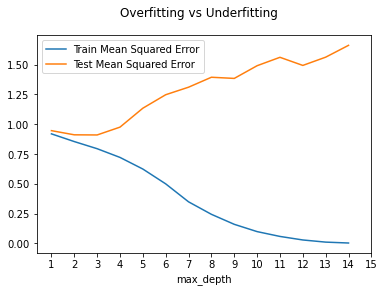

In [71]:
md_list = []
score_train_list = []
score_test_list = []
mse_train_list = []
mse_test_list = []

for maxdepth in list(range(1,15)):
  tree_model = DecisionTreeRegressor(random_state=0, max_depth=maxdepth)#, min_samples_split = 4)
  tree_model.fit(X_train, y_train)

  pred_train = tree_model.predict(X_train)
  pred_test = tree_model.predict(X_test)

  ## Generación de listas
  md_list.append(maxdepth)
  score_train_list.append(100.0*tree_model.score(X_train, y_train))
  score_test_list.append(100.0*tree_model.score(X_test, y_test))
  mse_train_list.append(mean_squared_error(y_train, pred_train))
  mse_test_list.append(mean_squared_error(y_test, pred_test))

df_maxdepth = pd.DataFrame({"max_depth":md_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list,
                   "mse_train":mse_train_list,
                   "mse_test":mse_test_list
                   })
df_maxdepth.set_index("max_depth", inplace=True)

df_maxdepth["mse_train"].plot(label="Train Mean Squared Error")
df_maxdepth["mse_test"].plot(label="Test Mean Squared Error")
plt.xticks(range(1,16))
plt.suptitle("Overfitting vs Underfitting")
plt.legend()
plt.show()

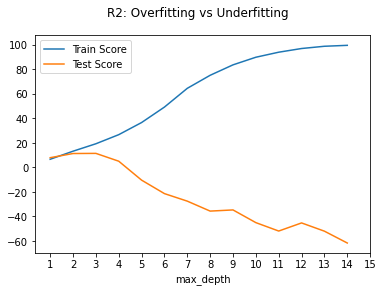

In [72]:
df_maxdepth["score_train"].plot(label="Train Score")
df_maxdepth["score_test"].plot(label="Test Score")
plt.suptitle("R2: Overfitting vs Underfitting")
plt.xticks(range(1,16))
plt.legend()
plt.show();

In [73]:
#Elijo un AD con 4 de max depth:

tree_model = DecisionTreeRegressor(random_state=0, max_depth=2)
tree_model.fit(X_train, y_train)

print(tree_model.score(X_train, y_train)*100.00,"%")
print(tree_model.score(X_test, y_test)*100.00,"%")

13.27154438699123 %
11.376221670842067 %


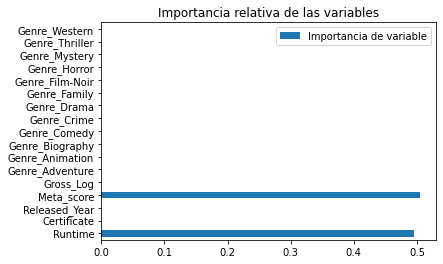

In [74]:
df_AD_imp = pd.DataFrame(tree_model.feature_importances_.reshape(1,-1), columns=X_train.columns, index=["Importancia de variable"])
df_AD_imp.T.plot.barh()
plt.legend()
plt.title("Importancia relativa de las variables")
plt.show()

In [75]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
model = XGBRegressor()
model.fit(X_train, y_train)
Y_pred = model.predict(X_test)
score = model.score(X_train, y_train)
print('Training Score:', score)
score = model.score(X_test, y_test)
print('Testing Score:', score)
output = pd.DataFrame({'Predicted':Y_pred})

Training Score: 0.9982547382648065
Testing Score: -0.011397484349750187


In [76]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)
Y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test.values.ravel(), Y_pred)
mse = mean_squared_error(y_test.values.ravel(), Y_pred)
r2 = r2_score(y_test.values.ravel(), Y_pred)

# Print metrics
print('Mean Absolute Error:', round(mae, 2))
print('Mean Squared Error:', round(mse, 2))
print('R-squared:', round(r2, 2))
print('Train score: ', format(model.score(X_train, y_train),'.2%'))
print('Test score: ', format(model.score(X_test, y_test.values.ravel()),'.2%'))

Mean Absolute Error: 0.74
Mean Squared Error: 0.91
R-squared: 0.11
Train score:  87.15%
Test score:  11.18%
